# Working with Gaussians

## Estimating unobserved data
In this live script, we will be working with temperature data in Boston. We will use the concepts explored in this section to create estimates of unobserved data using Gaussian processes. 

### The Data (Avalilable in https://www.usclimatedata.com/)
Initially, lets load the data available for this example. We have two data sets

1. Weather information in Boston in the forms of averages from 1981 to 2010. We are provided with average high and low temperature precipitation and inches of snow for every day of the year.
2. Weather information in Boston in 2019. We are provided with average high and low temperature precipitation and inches of snow for every day of the year.

For simplicity we are going to work with the temperature information only.
The provided file 'data.mat' consis of 4 columns and 365 rows. Each row indicates a consecutuve day of the year. 
- Column 1 is the highest recorded temperature in Boston in 2019 in a particular day.
- Column 2 is the lowest recorded temperature in Boston in 2019 in a particular day.
- Column 3 is the average of the highest recorded temperatures in Boston from 1981 to 2010 in a particular day.
- Column 4 is the average of the lowest recorded temperature in Boston from 1981 to 2010 in a particular day.

Load the average data

In [ ]:
import scipy.io
!wget https://github.com/maxoboe/6419_recitations/blob/main/data/data.mat?raw=true
# rename the file
!mv data.mat\?raw\=true data.mat
# Load the data
d = scipy.io.loadmat('data.mat')
# d = scipy.io.loadmat("https://github.com/maxoboe/6419_recitations/blob/a6d75839e884fa066dbf66b0c95e2ee3ffcc9886/data/data.mat")
data = d['data'].T

--2021-11-29 19:44:52--  https://github.com/maxoboe/6419_recitations/blob/main/data/data.mat?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/maxoboe/6419_recitations/raw/main/data/data.mat [following]
--2021-11-29 19:44:52--  https://github.com/maxoboe/6419_recitations/raw/main/data/data.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/data.mat [following]
--2021-11-29 19:44:52--  https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awa

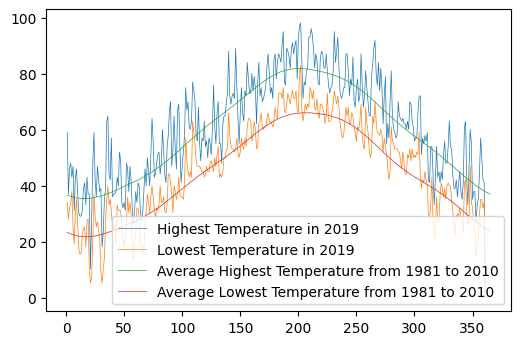

In [ ]:
# Visualize the data:
import numpy as  np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

x = np.arange(1, 366)
for i, label in enumerate([
                           "Highest Temperature in 2019",
                           "Lowest Temperature in 2019",
                           "Average Highest Temperature from 1981 to 2010",
                           "Average Lowest Temperature from 1981 to 2010"
                          ]):
  plt.plot(x, data[i], label=label, lw=0.5)
plt.legend()
plt.show()

**Note: Temperature information is missing for the last 5 days of 2019. Entries have been filled with zeros, but this does not mean the temperature is zero.**

### Partition the observed data for cross validation

We will use the described cross validaton process. Where we are going to partition the available observations $\mathbf{x}_2$ into $\kappa$ partitions. For simplicity lets initially pick $\kappa=2$ that is, we partition $\mathbf{x}_2$  into two groups.

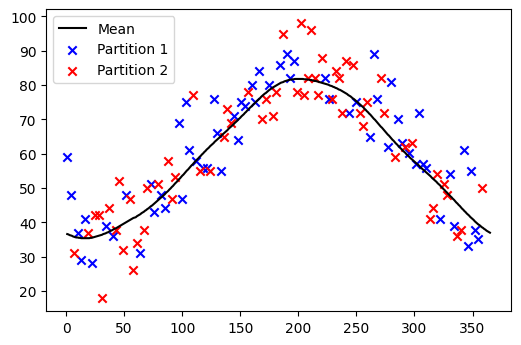

In [ ]:
ind_x2 = np.arange(0,360,3)
perm = np.random.permutation(ind_x2.shape[0])
idx_train, idx_test = [ ind_x2[a] for a in map(np.sort, np.split(perm, 2)) ]
y_train = data[0][idx_train]
y_test = data[0][idx_test]
mean_train = data[2][idx_train]
mean_test = data[2][idx_test]
for k_x2, label, c in [(idx_train, "Partition 1", 'b'), (idx_test, "Partition 2", 'r')]:
  plt.scatter(k_x2+1, data[0][k_x2], label=label, c=c, marker='x')

x = np.arange(1,366)
plt.plot(x, data[2], c='k', label="Mean")
plt.legend()
plt.show()

## Predicting with Tools from This Course
First, use the tools from earlier in this course to predict the missing values by fitting any periodic or polynomial patterns in the data. Report the test-set MSE from this attempt. 

You may find the solutions from the climate module helpful: https://colab.research.google.com/drive/1vJmoFJu0rSKdLZOqinD6Czr1vrVaEAIl?usp=sharing 

In [ ]:
## TODO: form predictions of the output values, using your existing toolbox. 

## Predicting with Gaussians
Now, predict the missing values using the assumption of Gaussianity and the covariance of the full series as a function of distance. Report the MSE for this attempt. 


Note that you can use arbitrarily many points to form this prediction; to simplify the problem, consider only the 5 closest values.

### Step 1: Autocovariance
Find the autocovariance of temperature as a function of time steps, using the full dataset. 
You may find this reference helpful: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acovf.html 

In [ ]:
# TODO: add code to find the autocovariance as a function of distance. 
import statsmodels.tsa.api as smt


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:354: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


### Step 2: Find closest 5 values for each point 
Find a function that returns the five closest values for each point. 

In [ ]:
# this code does not need changing 
def closest_values_in_train(idx, num_vals = 5):
  """
  Finds the five closest values in the training dataset 
  to the given index from the test dataset.
  Returns both the index of those values and the distances. 
  """
  distances = np.abs(idx_test - idx)
  sorted_indexes = distances.argsort()
  closest_indexes = sorted_indexes[0:num_vals]
  closest_distances = distances[closest_indexes]
  return closest_indexes, closest_distances
closest_indexes, closest_distances = closest_values_in_train(45)

array([48, 54, 33, 30, 63])

### Step 3: Predict using Gaussian Distribution
Use the formula for conditional expectation of multivariate Gaussians to find the predicted value at each missing observation. 

As a refresher, the formula is: 
$
\mu_{\mathbf{X}_2^i | \mathbf{X}_2^{-i}} = \mu_2^i + \Sigma_{\mathbf{X}_2^i,\mathbf{X}_2^{-i}} \Sigma_{\mathbf{X}_2^{-i},\mathbf{X}_2^{-i}}^{-1} (\mathbf{x}_2^{-i} - \mu_2^{-i})
$


Note that $\mu_{2}^i$ can be found as the average temperature at the given date from the historical record, and that $\Sigma$ is the matrix of covariance between all observations you're conditioning on. 
In our data, note that `data[2]` gives the series of the average highest recorded temperature. 

In [ ]:
# TODO: form these predictions 
# Suggestion: fill in these missing functions to predict for each observation, then loop over the data

# No need to change this block: computes the covariance matrix as a function of distance
# ----------------
# Should work as long as autocovar is a list of autocovariances of the test matrix 
distances = np.arange(1,366).reshape(-1,1) - np.arange(1,366).reshape(1,-1)
# Distances is a 365 x 365 matrix of predicted values, based on the distance 
acv_func = lambda x: autocovar[np.abs(x)]
vfunc = np.vectorize(acv_func)
sigma = vfunc(distances)
# ----------------
def predict_for_one_index(idx, num_vals=5):
  closest_indexes, closest_distances = closest_values_in_train(idx, num_vals)
  predicted_value = data[2][idx] + \
        autocovar[np.abs(closest_distances)].reshape(1,-1) @ \
        np.linalg.pinv(sigma[closest_distances.reshape(1,-1), closest_distances.reshape(-1,1)]) @ \
        (y_test[closest_indexes] - mean_test[closest_indexes]) 
  return predicted_value
print(predict_for_one_index(31))
print(data[0][31])

[24.72766971]
23.2


In [ ]:
closest_indexes

array([5, 6, 4, 3, 7])

In [ ]:
# Use the provided function to generate predictions
# Evaluate the performance of the provided function

38.9

## Predict using Kernel Function
Here, the framework is as in the above section; the only difference is that you will be filling in values from the covariance matrix with the provided kernel function. 

In [ ]:
theta1 = 4.2 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta2 = 0.4 #@param {type:"slider", min:0.1, max:10, step:0.1}

covs = np.arange(1,366).reshape(-1,1) - np.arange(1,366).reshape(1,-1)

sigma = theta1 * np.exp( - covs**2 / theta2**2 )
# Use the alternate sigma to repeat the steps above. 

(365, 1)